# Chapter 3 - Linear Regression

In [183]:
import warnings
warnings.filterwarnings('ignore')

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [184]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import cm

from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_theme()
sns.set_style("ticks")
# plt.style.use('seaborn-white')

### Load Datasets
Datasets available on https://www.statlearning.com/resources-second-edition

In [185]:
advertising = pd.read_csv('https://www.statlearning.com/s/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [186]:
credit = pd.read_csv('https://www.statlearning.com/s/Credit.csv')
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance,Student2
0,14.891,3606,283,2,34,11,No,No,Yes,South,333,0
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903,1
2,104.593,7075,514,4,71,11,No,No,No,West,580,0


In [187]:
auto = pd.read_csv('https://www.statlearning.com/s/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

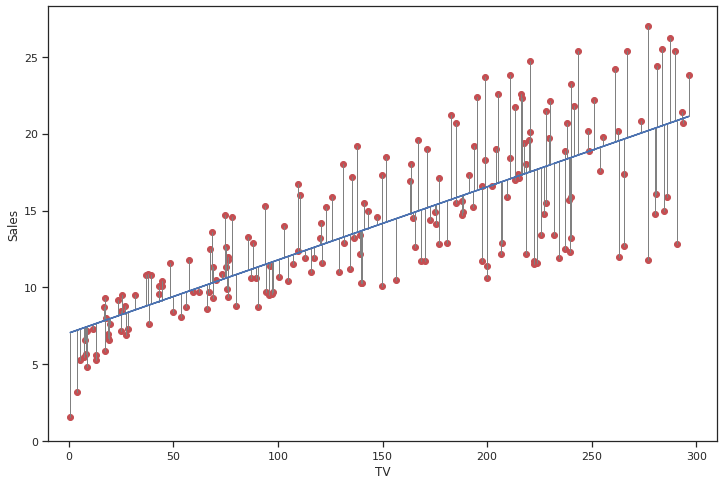

In [188]:
fig, ax = plt.subplots(figsize=(12,8))
x   = advertising.TV
m,b = np.polyfit(advertising.TV, advertising.sales,1)
y= m*x+b
for i in range(len(x)):
    ax.plot([advertising.TV[i], x[i]], [y[i], advertising.sales[i]] ,'-', color='grey', linewidth=1)
ax.scatter('TV','sales', data=advertising, color='r')
ax.plot(x, y, color='b')
ax.set_ylabel('Sales')
ax.set_xlabel('TV')
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [189]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


In [190]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

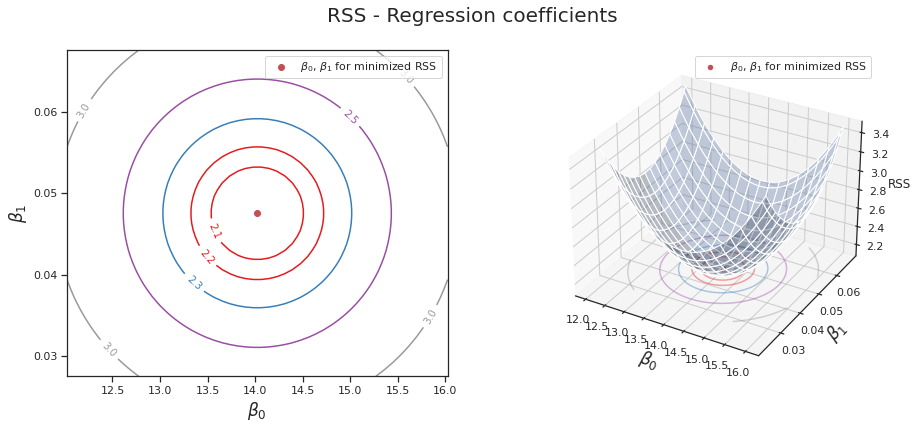

In [191]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Figure 3.3

simulate for $f(X) = 2 + 3X + \epsilon$

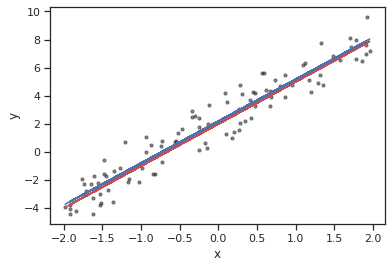

In [192]:
np.random.seed(0)
x = np.random.uniform(low=-2, high=2, size=(100,))
y = 2 + 3 * x + np.random.normal(0,1,100)
y_true = 2 + 3 * x

b0, b1= np.polyfit(x,y,1)

# plot
plt.scatter(x,y,s=10, color='k', alpha=0.5)
plt.plot(x, y_true, color ='r')
plt.plot(x, b1+b0*x, color='b')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Confidence interval on page 67 & Table 3.1 & 3.2 - Statsmodels 

In [193]:
est = smf.ols('sales ~ TV', advertising).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053


In [194]:
print(est.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           1.47e-42
Time:                        16:57:50   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         


In [195]:
# RSS with regression coefficients
n = advertising.shape[0]
RSS = ((advertising.sales - (est.params[0] + est.params[1]*advertising.TV))**2).sum()
RSE = (1/(n-2)*RSS)**0.5
print(f'RSE\t{RSE:.2f}')

RSE	3.26


### Table 3.1 & 3.2 - Scikit-learn

In [196]:
regr = skl_lm.LinearRegression()

X = advertising.TV.values.reshape(-1,1)
y = advertising.sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

7.032593549127693
[0.04753664]


In [197]:
Sales_pred = regr.predict(X)
r2_score(y, Sales_pred)

0.611875050850071

## 3.2 Multiple Linear Regression

### Table 3.3 - Statsmodels

In [198]:
est = smf.ols('sales ~ radio', advertising).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.000       8.202      10.422
radio          0.2025      0.020      9.921      0.000       0.162       0.243


In [199]:
est = smf.ols('sales ~ newspaper', advertising).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.000      11.126      13.577
newspaper      0.0547      0.017      3.300      0.001       0.022       0.087


### Table 3.4 & 3.6 - Statsmodels

In [200]:
est = smf.ols('sales ~ TV + radio + newspaper', advertising).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Wed, 21 Sep 2022   Prob (F-statistic):           1.58e-96
Time:                        16:57:51   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

### Table 3.5 - Correlation Matrix

In [201]:
advertising.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


### Figure 3.5 - Multiple Linear Regression

In [202]:
scaler = StandardScaler()
regr = skl_lm.LinearRegression()

X = scaler.fit_transform(advertising[['radio', 'TV']].values)
y = advertising.sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051362


In [203]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['radio', 'TV', 'sales']].describe()

,radio,TV,sales
count,200.000000,200.000000,200.000000
mean,23.264000,147.042500,14.022500
std,14.846809,85.854236,5.217457
min,0.000000,0.700000,1.600000
25%,9.975000,74.375000,10.375000
50%,22.900000,149.750000,12.900000
75%,36.525000,218.825000,17.400000
max,49.600000,296.400000,27.000000


In [204]:
# Create a coordinate grid
Radio = np.arange(0,50,2)
TV = np.arange(0,300,10)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

Z = regr.intercept_ + regr.coef_[0]*B1 + regr.coef_[1]*B2

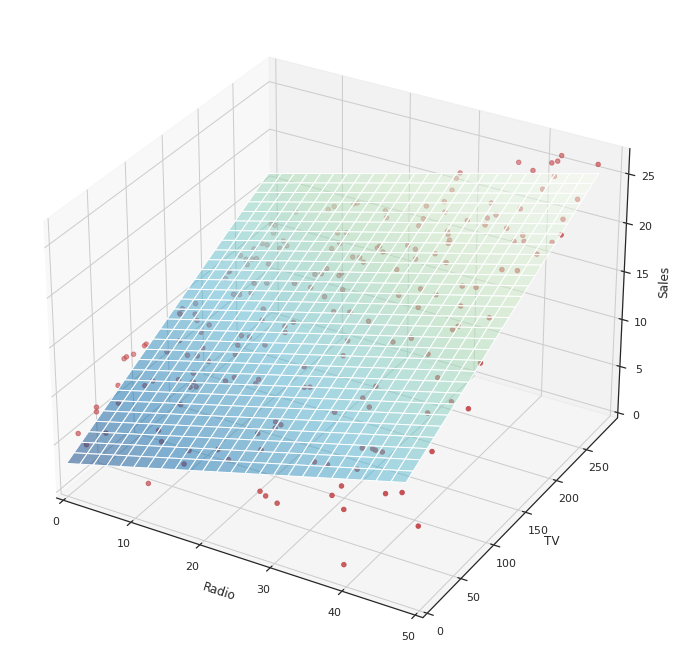

In [205]:
# Create plot
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_surface(B1, B2, Z, alpha=0.5, cmap=cm.GnBu_r)
ax.scatter3D(advertising.radio, advertising.TV, advertising.sales, c='r')

ax.set_xlim(0, 50)
ax.set_ylim(0, 297)
ax.set_zlim(0, 27)
ax.set_xlabel('Radio')
ax.set_ylabel('TV')
ax.set_zlabel('Sales');

## 3.3 Other Considerations in the Regression Model

### Figure 3.6

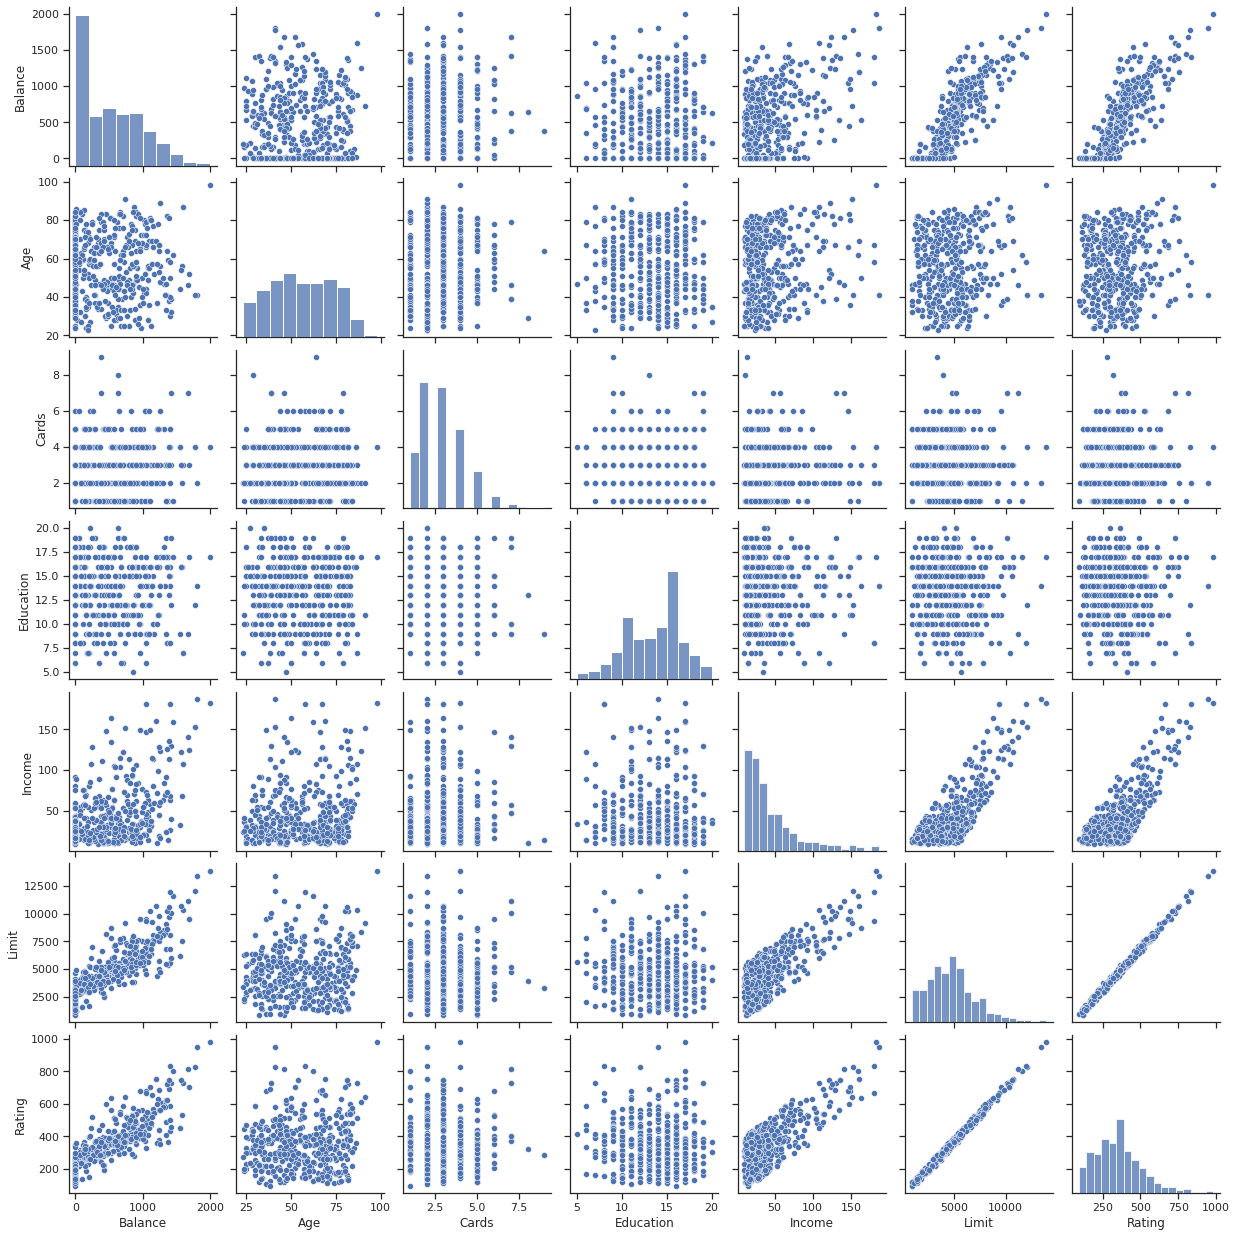

In [206]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

###  Table 3.7

In [207]:
est = smf.ols('Balance ~ Own', credit).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    509.8031     33.128     15.389      0.000     444.675     574.931
Own[T.Yes]    19.7331     46.051      0.429      0.669     -70.801     110.267


### Table 3.8

In [208]:
est = smf.ols('Balance ~ Region', credit).fit()
print(est.summary().tables[1])

                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         531.0000     46.319     11.464      0.000     439.939     622.061
Region[T.South]   -12.5025     56.681     -0.221      0.826    -123.935      98.930
Region[T.West]    -18.6863     65.021     -0.287      0.774    -146.515     109.142


### Table 3.9 - Interaction Variables

In [209]:
est = smf.ols('sales ~ TV + radio + TV*radio', advertising).fit()
print(est.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7502      0.248     27.233      0.000       6.261       7.239
TV             0.0191      0.002     12.699      0.000       0.016       0.022
radio          0.0289      0.009      3.241      0.001       0.011       0.046
TV:radio       0.0011   5.24e-05     20.727      0.000       0.001       0.001


### Figure 3.7 - Interaction between qualitative and quantative variables

In [210]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


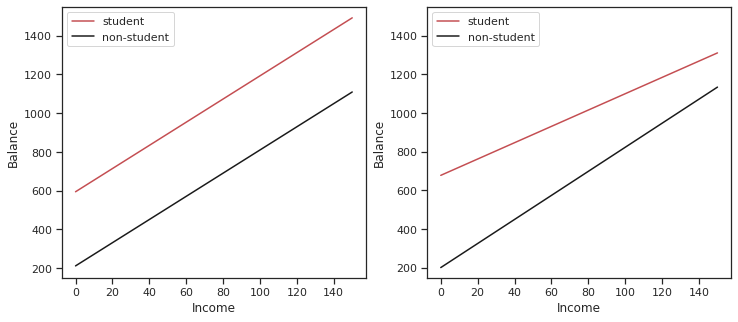

In [211]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

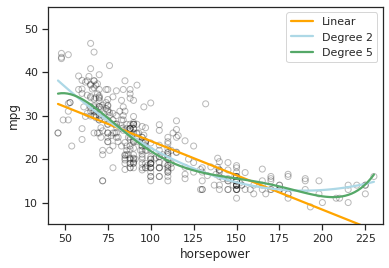

In [212]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(x=auto.horsepower, y=auto.mpg, facecolors='None', edgecolors='k', alpha=.3) 
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,235);

### Table 3.10

In [213]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,16900.0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,27225.0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,22500.0


In [214]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
print(est.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      56.9001      1.800     31.604      0.000      53.360      60.440
horsepower     -0.4662      0.031    -14.978      0.000      -0.527      -0.405
horsepower2     0.0012      0.000     10.080      0.000       0.001       0.001


### Figure 3.9

In [215]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].values
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

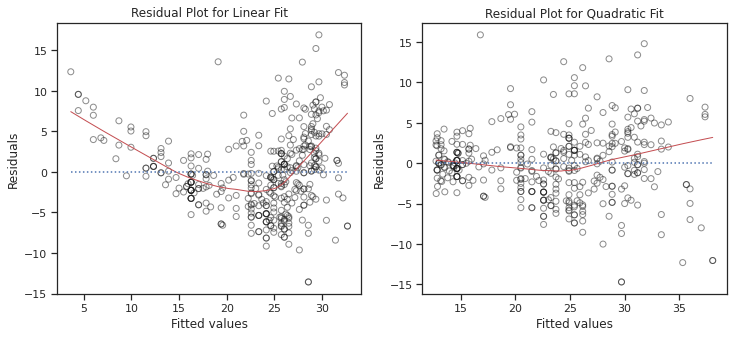

In [216]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(x=auto.pred1, y=auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(x=auto.pred2, y=auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

### Figure 3.14

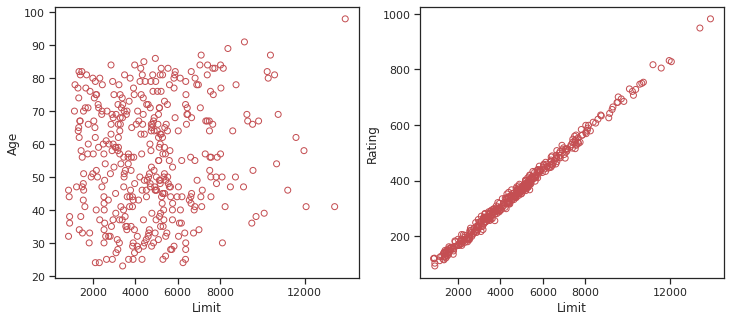

In [217]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [218]:
y = credit.Balance

# Regression for left plot
X = credit[['Age', 'Limit']].values
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']].values
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.0150000000001
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[2.20167217 0.02451438]


In [219]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

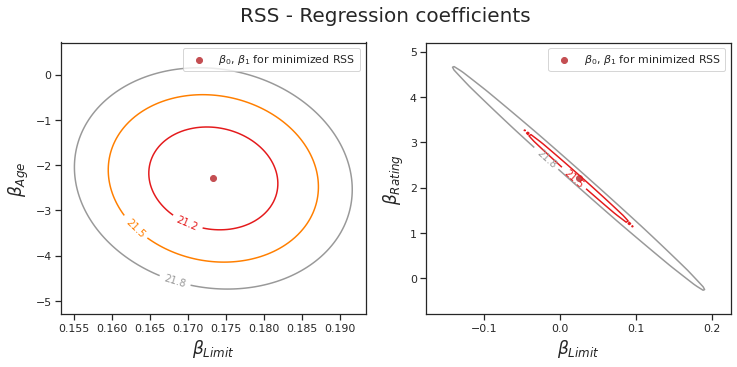

In [220]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

### Table 3.11

In [221]:
print(smf.ols('Balance ~ Age + Limit', credit).fit().summary().tables[1])
print(smf.ols('Balance ~ Rating + Limit', credit).fit().summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -173.4109     43.828     -3.957      0.000    -259.576     -87.246
Age           -2.2915      0.672     -3.407      0.001      -3.614      -0.969
Limit          0.1734      0.005     34.496      0.000       0.163       0.183
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -377.5368     45.254     -8.343      0.000    -466.505    -288.569
Rating         2.2017      0.952      2.312      0.021       0.330       4.074
Limit          0.0245      0.064      0.384      0.701      -0.101       0.150


### Variance Inflation Factor - page 102

In [222]:
est_Age = smf.ols('Age ~ Rating + Limit', credit).fit()
est_Rating = smf.ols('Rating ~ Age + Limit', credit).fit()
est_Limit = smf.ols('Limit ~ Age + Rating', credit).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))

1.0113846860681328
160.66830095856935
160.59287978597942
